## MSBA316 – Text Analytics & NLP

### Dr. Pauline Mouawad

### Project 2: Movie Classifier and Recommender System

- Zahraa Berjawi
- Carla Sfeir
- Maha Weiss

#### Summer 2020-2021

# Setup

In [1]:
import pandas as pd
from pandas import DataFrame

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

import numpy as np
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import string
import random
from random import sample
import re
import gensim
from gensim.models import LdaModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk import RegexpParser

import matplotlib.pyplot as plt


from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud

from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'spacy'

# Loading Data

In [21]:
movie_total = pd.read_csv('movie_reviews.csv')

##### We decided to work on a sample of 2,000 records to prevent problems in processing large size files

In [22]:
movie = movie_total.iloc[:int(2000)]

In [23]:
movie['sentiment'].value_counts()

positive    1005
negative     995
Name: sentiment, dtype: int64

In [24]:
movie.head()

,review,sentiment,genre,title
0,One of the other reviewers has mentioned that ...,positive,Romance,Miss Jerry
1,A wonderful little production. <br /><br />The...,positive,"Biography, Crime, Drama",The Story of the Kelly Gang
2,I thought this was a wonderful way to spend ti...,positive,Drama,Den sorte drøm
3,Basically there's a family where a little boy ...,negative,"Drama, History",Cleopatra
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Adventure, Drama, Fantasy",L'Inferno


In [25]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     2000 non-null   object
 1   sentiment  2000 non-null   object
 2   genre      2000 non-null   object
 3   title      2000 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


## Encoding String Values
##### "Sentiment" Column

In [26]:
movie['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [27]:
movie['sentiment'] = movie['sentiment'].replace({'negative': 0, 'positive': 1})

movie.head()

,review,sentiment,genre,title
0,One of the other reviewers has mentioned that ...,1,Romance,Miss Jerry
1,A wonderful little production. <br /><br />The...,1,"Biography, Crime, Drama",The Story of the Kelly Gang
2,I thought this was a wonderful way to spend ti...,1,Drama,Den sorte drøm
3,Basically there's a family where a little boy ...,0,"Drama, History",Cleopatra
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"Adventure, Drama, Fantasy",L'Inferno


# Module 1

## Normalization

### Defining functions for normalization of "review" column

#### Removing special characters and stopwords and URLs, Lemmatization, and Stemming

In [28]:
# Tokenization
def tokenize_text(text):
    tokens = word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens


# Removing Special Characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text


# Removing Stopwords
stopword_list = stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenize_text(text)
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Lemmatizing text
def lemmatize_text(text):
    Lemmatize = WordNetLemmatizer()
    tokens = tokenize_text(text)
    tokens = [Lemmatize.lemmatize(token) for token in tokens]
    text = ' '.join(tokens)
    return text
    
# Stemming text : method used depends on input
def stem_text(text):
    ps = PorterStemmer()
    tokens = tokenize_text(text)
    tokens = [ps.stem(token) for token in tokens]
    text = ' '.join(tokens)
    return text


# Removing URLs
def cleaning_URLs(text):
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)
    return text

# Putting the functions all together
def normalize_sentences(corpus, special_char_removal=True, 
                        text_lemmatization=True,cleaning_urls=True, text_lower_case=True,
                     cleaning_num = True, stopword_removal=True, text_stemming = True
                     ):
    normalized_corpus = []
    
    for doc in corpus:
        
        if text_stemming:
            doc = stem_text(doc)

        if text_lower_case:
            doc = doc.lower()
            


        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        
      
        if text_lemmatization:
            doc = lemmatize_text(doc)
            
        if special_char_removal:
            doc = remove_special_characters(doc)  


        if cleaning_urls:
            doc = cleaning_URLs(doc)
            
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus


#### Tokenization followed by: Removing special characters and stopwords and URLs, and Lemmatization. 
Then we joined the review words into sentences through the function

In [6]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)

In [23]:
from pandas import DataFrame
df_reviews = DataFrame(review_normalized, columns =['review'] )
df_reviews.head()

,review
0,one reviewer ha mentioned watching 1 oz episod...
1,wonderful little production br br filming tech...
2,thought wa wonderful way spend time hot summer...
3,basically family little boy jake think zombie ...
4,petter mattei love time money visually stunnin...


In [24]:
movie['review'] = df_reviews['review']
movie.head()

,review,sentiment,genre,title
0,one reviewer ha mentioned watching 1 oz episod...,1,Romance,Miss Jerry
1,wonderful little production br br filming tech...,1,"Biography, Crime, Drama",The Story of the Kelly Gang
2,thought wa wonderful way spend time hot summer...,1,Drama,Den sorte drøm
3,basically family little boy jake think zombie ...,0,"Drama, History",Cleopatra
4,petter mattei love time money visually stunnin...,1,"Adventure, Drama, Fantasy",L'Inferno


In [25]:
# Checking for missing values
movie.isnull().value_counts()

review  sentiment  genre  title
False   False      False  False    2000
dtype: int64

# Module 2

##  Feature Engineering 

### Bag of Words (Sparse Matrix)

In [26]:
# Identifying "Review" column as training set
X = movie.review

X

0       one reviewer ha mentioned watching 1 oz episod...
1       wonderful little production br br filming tech...
2       thought wa wonderful way spend time hot summer...
3       basically family little boy jake think zombie ...
4       petter mattei love time money visually stunnin...
                              ...                        
1995    feeling minnesota directed steven baigelmann s...
1996    cell 2000 rating 810 br br cell like antz must...
1997    movie despite list b c list celebs complete wa...
1998    loved movie wa could break tear watching reall...
1999    wa worst movie ever seen billy zane understand...
Name: review, Length: 2000, dtype: object

In [27]:
cv = CountVectorizer()
X_CV = cv.fit_transform(X)

In [28]:
pd.DataFrame.sparse.from_spmatrix(X_CV[50:150])

,0,1,2,3,4,5,6,7,8,9,...,24183,24184,24185,24186,24187,24188,24189,24190,24191,24192
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF (Sparse Matrix)

In [29]:
v1 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v1.fit_transform(X)

In [30]:
pd.DataFrame.sparse.from_spmatrix(X_TFIDF[50:150])

,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.031285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Module 3

## Testing Different Normalization and Feature Engineering Techniques

### Bag of Words

#### Naive Bayes - Lemmatization BoW 

##### Removing special characters and stopwords and URLs and digits, Lower case, Lemmatization and NO stemming

In [19]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
#Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier NB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

#Accuracy
accuracy_bow1 = accuracy_score(y_test, y_pred)

accuracy_bow1

0.625

#### Naive Bayes - Stemming BoW

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming and NO Lemmatization

In [20]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=False, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
# Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier NB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

# Accuracy
accuracy_bow2 = accuracy_score(y_test, y_pred)

accuracy_bow2

0.6

#### Naive Bayes - Lemmatization & Stemming BoW

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming AND Lemmatization

In [21]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
# Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

# Accuracy
accuracy_bow3 = accuracy_score(y_test, y_pred)

accuracy_bow3

0.6

#### Logistic Regression - Lemmatization BoW

##### Removing special characters and stopwords and URLs and digits, Lower case, Lemmatization and NO Stemming

In [22]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
# Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier LR
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

# Accuracy
accuracy_bow4 = accuracy_score(y_test, y_pred)

accuracy_bow4

0.8225

#### Logistic Regression - Stemming BoW

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming and NO Lemmatization

In [23]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=False, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
# Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier LR
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

# Accuracy
accuracy_bow5 = accuracy_score(y_test, y_pred)

accuracy_bow5

0.8125

#### Logistic Regression - Lemmatization & Stemming BoW

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming AND Lemmatization

In [24]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
# Feature engineering: 
X = review_normalized
y = movie.sentiment

cv = CountVectorizer()
X_CV = cv.fit_transform(X)


# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_CV, y, test_size= 0.2, random_state = 45)

X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier LR
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

# Accuracy
accuracy_bow6 = accuracy_score(y_test, y_pred)

accuracy_bow6

0.8125

### TF-IDF

#### Naive Bayes - Lemmatization TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Lemmatization and NO Stemming

In [25]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
# Feature engineering: 
X = review_normalized
y = movie.sentiment
v1 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v1.fit_transform(X)

# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier NB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

#Accuracy
accuracy_tfidf1 = accuracy_score(y_test, y_pred)
accuracy_tfidf1

0.705

#### Naive Bayes - Stemming TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming and NO Lemmatization

In [26]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=False, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
#Feature engineering: 
X = review_normalized
y = movie.sentiment
v2 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v2.fit_transform(X)

#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

#Accuracy
accuracy_tfidf2 = accuracy_score(y_test, y_pred)
accuracy_tfidf2

0.7025

#### Naive Bayes - Lemmatization & Stemming TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming AND Lemmatization

In [27]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
#Feature engineering: 
X = review_normalized
y = movie.sentiment
v3 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v3.fit_transform(X)

#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

y_pred = classifier_nb.predict(X_test)

#Accuracy
accuracy_tfidf3 = accuracy_score(y_test, y_pred)
accuracy_tfidf3

0.7025

#### Logistic Regression - Lemmatization TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Lemmatization and NO Stemming

In [28]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
#Feature engineering: 
X = review_normalized
y = movie.sentiment
v1 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v1.fit_transform(X)

#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

#Accuracy
accuracy_tfidf4 = accuracy_score(y_test, y_pred)
accuracy_tfidf4

0.85

#### Logistic Regression - Stemming TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming and NO Lemmatization

In [29]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=False, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
#Feature engineering: 
X = review_normalized
y = movie.sentiment
v2 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v2.fit_transform(X)

#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

#Accuracy
accuracy_tfidf5 = accuracy_score(y_test, y_pred)
accuracy_tfidf5

0.8475

#### Logistic Regression - Lemmatization & Stemming TF-IDF

##### Removing special characters and stopwords and URLs and digits, Lower case, Stemming AND Lemmatization

In [30]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = True)
#Feature engineering: 
X = review_normalized
y = movie.sentiment
v3 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v3.fit_transform(X)

#Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

#Applying Classifier
classifier_lr = LogisticRegression()
classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

#Accuracy
accuracy_tfidf6 = accuracy_score(y_test, y_pred)
accuracy_tfidf6

0.8475

#### Printing All the Results

In [31]:
pd.DataFrame([['Gaussian Naive Bayes',accuracy_bow1,accuracy_bow2,accuracy_bow3, accuracy_tfidf1,accuracy_tfidf2,accuracy_tfidf3],
               ['Logistic Regression',accuracy_bow4,accuracy_bow5,accuracy_bow6, accuracy_tfidf4,accuracy_tfidf5,accuracy_tfidf6]
            ],
            columns= ['Accuracy', 'Lemmatization-Bag of Words', 'Stemming-Bag of Words', 'Lemmatization&Stemming-Bag of Words',
                      'Lemmatization-TFIDF', 'Stemming-TFIDF', 'Lemmatization&Stemming-TFIDF']).T

,0,1
Accuracy,Gaussian Naive Bayes,Logistic Regression
Lemmatization-Bag of Words,0.625,0.8225
Stemming-Bag of Words,0.6,0.8125
Lemmatization&Stemming-Bag of Words,0.6,0.8125
Lemmatization-TFIDF,0.705,0.85
Stemming-TFIDF,0.7025,0.8475
Lemmatization&Stemming-TFIDF,0.7025,0.8475


#### Chosen Model to Tune: Logistic Regression + TF-IDF + Preprocessing (Lemmatization)

## Hyperparameter Tuning for Chosen Model

In [ ]:
review_normalized = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
# Feature engineering TF-IDF: 
X = review_normalized
y = movie.sentiment
v1 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v1.fit_transform(X)

# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

# Define models and parameters LR
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 1.0, 0.01]

# Define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

### Logistic Regression Model with Best Parameters

In [29]:
review_normalized_lr = normalize_sentences(corpus= movie['review'], special_char_removal=True, 
                        text_lemmatization=True, cleaning_urls=True, text_lower_case=True,
                        cleaning_num = True, stopword_removal=True,text_stemming = False)
# Feature engineering TF-IDF: 
X = review_normalized_lr
y = movie.sentiment
v3 = TfidfVectorizer(ngram_range=(1,2), max_features= 50000) 
X_TFIDF = v3.fit_transform(X)

# Splitting Data 
X_train, X_test, y_train, y_test = train_test_split(X_TFIDF, y, test_size= 0.2, random_state = 45)
X_train = X_train.todense()
X_test = X_test.todense()

# Applying Classifier LR
classifier_final_lr = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
classifier_final_lr.fit(X_train, y_train)
y_pred = classifier_final_lr.predict(X_test)

# Accuracy
accuracy_final_lr = accuracy_score(y_test, y_pred)
accuracy_final_lr

0.845

## Confusion Matrix: Logistic Regression - TF-IDF - Lemmatization

### Summary of predictive results in the classification

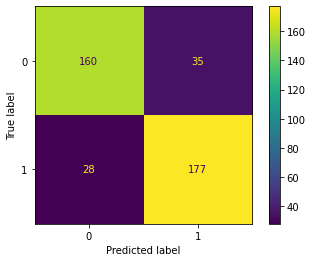

In [34]:
plot_confusion_matrix(classifier_final_lr, X_test, y_test)
plt.show()

- True Positive: 177 predicted as positive reviews and they actually are.
- True Negative: 160 predicted as negative reviews and they actually are.
- False Positive (Type 1 Error): 35 predicted as positive reviews but they actually are negative reviews.
- False Negative (Type 2 Error): 28 predicted as negative reviews but they actually are positive reviews.

# Module 4

## Combining Genre and Sentiment Columns

In [35]:
movie_total2 = pd.read_csv('movie_reviews.csv')
movie2 = movie_total2.iloc[:int(2000)]

In [36]:
movie2['genre_sentiment'] = movie2['genre'] + ', ' + movie2['sentiment']

In [37]:
movie2['genre_sentiment']

0                         Romance, positive
1         Biography, Crime, Drama, positive
2                           Drama, positive
3                  Drama, History, negative
4       Adventure, Drama, Fantasy, positive
                       ...                 
1995                        Drama, negative
1996       Comedy, Crime, Romance, positive
1997              Comedy, Musical, negative
1998           Biography, Western, positive
1999    Action, Adventure, Comedy, negative
Name: genre_sentiment, Length: 2000, dtype: object

## Text Vectorization using TF-IDF

In [38]:
v = TfidfVectorizer(ngram_range=(2,4), max_features=500000) #ngram range is set as (minimum features, max features)

genre_sent_features = v.fit_transform(movie2['genre_sentiment'])

genre_sent_features

<2000x775 sparse matrix of type '<class 'numpy.float64'>'
	with 7132 stored elements in Compressed Sparse Row format>

In [39]:
feature_names = v.get_feature_names()
feature_names

['action adventure',
 'action adventure comedy',
 'action adventure comedy negative',
 'action adventure comedy positive',
 'action adventure crime',
 'action adventure crime negative',
 'action adventure crime positive',
 'action adventure drama',
 'action adventure drama negative',
 'action adventure drama positive',
 'action adventure fantasy',
 'action adventure fantasy positive',
 'action adventure history',
 'action adventure history positive',
 'action adventure mystery',
 'action adventure mystery positive',
 'action adventure negative',
 'action adventure positive',
 'action adventure romance',
 'action adventure romance negative',
 'action adventure romance positive',
 'action adventure sci',
 'action adventure sci fi',
 'action adventure thriller',
 'action adventure thriller negative',
 'action adventure western',
 'action adventure western negative',
 'action biography',
 'action biography drama',
 'action biography drama negative',
 'action comedy',
 'action comedy drama'

## Cosine Similarity on Vectorized Text

In [40]:
cos_sim_genre_sent = cosine_similarity(genre_sent_features, genre_sent_features)
type(cos_sim_genre_sent)

numpy.ndarray

In [41]:
cos_sim_df = pd.DataFrame(cos_sim_genre_sent, index= movie['title'], columns = movie['title'])
cos_sim_df

title,Miss Jerry,The Story of the Kelly Gang,Den sorte drøm,Cleopatra,L'Inferno,"From the Manger to the Cross; or, Jesus of Nazareth",Madame DuBarry,Quo Vadis?,Independenta Romaniei,Richard III,...,Two Alone,Ukikusa monogatari,Upperworld,Rocky Mountain Mystery,La verbena de la Paloma,Der verlorene Sohn,A Very Honorable Guy,Vesyolye rebyata,Viva Villa!,Wagon Wheels
title,,,,,,,,,,,,,,,,,,,,,
Miss Jerry,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.221726,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.208033,0.0,0.0,0.0
The Story of the Kelly Gang,0.000000,1.000000,0.198812,0.0,0.0,0.058873,0.000000,0.0,0.0,0.198812,...,0.0,0.198812,0.054783,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Den sorte drøm,0.000000,0.198812,1.000000,0.0,0.0,0.296123,0.000000,0.0,0.0,1.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
Cleopatra,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
L'Inferno,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Der verlorene Sohn,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0
A Very Honorable Guy,0.208033,0.000000,0.000000,0.0,0.0,0.000000,0.046126,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0
Vesyolye rebyata,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.584919,0.0,0.000000,1.0,0.0,0.0


## Recommender Based on Genre and Sentiment

In [42]:
def genre_recommendations(i, df, items, k=10):
    """
    Recommends movies based on a similarity dataframe

    Parameters
    ----------
    i: Movie Name(str)
    df: pd.DataFrame (Cosine Similarity dataframe)
    items: pd.DataFrame (Contains both the movie title and features used to define similarity)
    k: int (Amount of recommendations to return)

    """
    ix = df.loc[:,i].to_numpy().argpartition(range(-1,-k,-1))
    closest = df.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(i, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

In [43]:
genre_recommendations('Wagon Wheels', cos_sim_df, movie2[['title', 'genre_sentiment']])

,title,genre_sentiment
0,The Big Chance,"Action, Adventure, Comedy, negative"
1,The Three Must-Get-Theres,"Action, Adventure, Comedy, negative"
2,Scarlet River,"Action, Adventure, Comedy, negative"
3,A Girl in Every Port,"Action, Adventure, Comedy, negative"
4,The Savage Girl,"Adventure, Comedy, negative"
5,Son of a Sailor,"Adventure, Comedy, negative"
6,Flirting with Fate,"Adventure, Comedy, negative"
7,Mr. Robinson Crusoe,"Action, Adventure, Comedy, positive"
8,Chu Chin Chow,"Action, Adventure, Comedy, positive"
9,Perils of Pauline,"Action, Adventure, Comedy, positive"


In [44]:
movie2['genre'].loc[movie2['title'] == 'Wagon Wheels']

1999    Action, Adventure, Comedy
Name: genre, dtype: object

# Module 5

## Topic Modeling with LDA on Logistic Regression Model with Best Parameters

In [1]:
processed_reviews = pd.DataFrame(review_normalized_lr, columns = ['reviews'])


processed_reviews = processed_reviews['reviews'].apply(lambda tx: word_tokenize(tx))


processed_reviews.head()

NameError: name 'pd' is not defined

In [46]:
# Create a dictionary from "processed_review":

dictionary = gensim.corpora.Dictionary(processed_reviews)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [47]:
# Generating tuples that contain unique id of each word and its frequency

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_reviews]


### Exploration of the Dictionary

In [48]:
bow_corpus[1500]

[(4, 1),
 (9, 2),
 (19, 1),
 (25, 1),
 (90, 1),
 (94, 1),
 (107, 1),
 (108, 1),
 (117, 1),
 (124, 2),
 (125, 1),
 (174, 1),
 (197, 2),
 (198, 2),
 (204, 2),
 (231, 1),
 (242, 1),
 (285, 1),
 (307, 1),
 (330, 4),
 (346, 1),
 (352, 1),
 (357, 2),
 (367, 1),
 (372, 1),
 (439, 1),
 (444, 1),
 (484, 1),
 (492, 1),
 (508, 1),
 (512, 1),
 (517, 1),
 (531, 1),
 (585, 1),
 (591, 1),
 (594, 1),
 (617, 1),
 (650, 2),
 (656, 3),
 (694, 3),
 (695, 1),
 (720, 1),
 (750, 1),
 (786, 1),
 (828, 1),
 (845, 1),
 (987, 1),
 (1213, 1),
 (1384, 1),
 (1447, 1),
 (1530, 1)]

In [49]:
print(bow_corpus[:100])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 3), (30, 1), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 4), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 4), (89, 1), (90, 2), (91, 1), (92, 2), (93, 2)], [(35, 1), (37, 1), (38, 2), (41, 1), (70, 1), (71, 1), (82, 1), (86, 1), (90, 1), (91, 3), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 

In [50]:
dictionary[100]

'entire'

In [51]:
# Printing gensim dictionary values

for i, j in dictionary.token2id.items():
    print(i, j)

1 0
appeal 1
around 2
audience 3
away 4
become 5
called 6
cell 7
charm 8
city 9
class 10
classic 11
could 12
dare 13
dealing 14
death 15
developed 16
doe 17
drug 18
due 19
episode 20
ever 21
exactly 22
experience 23
face 24
fact 25
far 26
first 27
focus 28
forget 29
front 30
get 31
given 32
glass 33
go 34
got 35
graphic 36
guard 37
ha 38
happened 39
high 40
home 41
hooked 42
italian 43
kill 44
lack 45
level 46
main 47
mainly 48
mainstream 49
many 50
may 51
mentioned 52
mess 53
middle 54
nasty 55
never 56
order 57
picture 58
pretty 59
prison 60
pull 61
punch 62
ready 63
regard 64
reviewer 65
right 66
romance 67
saw 68
say 69
scene 70
set 71
sex 72
show 73
side 74
skill 75
sold 76
state 77
street 78
surreal 79
taste 80
thats 81
thing 82
touch 83
trust 84
turned 85
use 86
viewing 87
violence 88
watched 89
watching 90
well 91
word 92
would 93
actor 94
come 95
comedy 96
done 97
dream 98
editing 99
entire 100
every 101
extremely 102
fantasy 103
fashion 104
filming 105
flat 106
give 107
great

In [52]:
#Previewing Results
bow_review_sample = bow_corpus[1000]

for i in range(len(bow_review_sample)):
    print("Word {} (\"{}\") appears {} time.".format(bow_review_sample[i][0], dictionary[bow_review_sample[i][0]], bow_review_sample[i][1]))

Word 21 ("ever") appears 1 time.
Word 24 ("face") appears 2 time.
Word 35 ("got") appears 3 time.
Word 38 ("ha") appears 1 time.
Word 47 ("main") appears 1 time.
Word 69 ("say") appears 1 time.
Word 86 ("use") appears 1 time.
Word 107 ("give") appears 1 time.
Word 117 ("play") appears 1 time.
Word 121 ("really") appears 1 time.
Word 142 ("character") appears 2 time.
Word 148 ("even") appears 1 time.
Word 183 ("10") appears 1 time.
Word 185 ("basically") appears 1 time.
Word 186 ("boy") appears 1 time.
Word 206 ("shot") appears 1 time.
Word 215 ("acting") appears 1 time.
Word 268 ("boring") appears 1 time.
Word 286 ("seen") appears 1 time.
Word 287 ("slow") appears 1 time.
Word 303 ("line") appears 2 time.
Word 329 ("awful") appears 1 time.
Word 330 ("bad") appears 1 time.
Word 334 ("ca") appears 1 time.
Word 355 ("comment") appears 1 time.
Word 367 ("least") appears 1 time.
Word 449 ("apparently") appears 1 time.
Word 491 ("suck") appears 1 time.
Word 508 ("saying") appears 1 time.
Wor

### LDA using BoW

#### A list of 10 topics

In [53]:
lda_model = LdaModel(bow_corpus, num_topics=10, id2word=dictionary)

for idx, topic in lda_model.print_topics():
    print('\n Topic: {} \t Word: {}'.format(idx, topic))


 Topic: 0 	 Word: 0.012*"like" + 0.008*"would" + 0.007*"see" + 0.007*"well" + 0.006*"scene" + 0.006*"bad" + 0.006*"time" + 0.006*"even" + 0.006*"people" + 0.005*"doe"

 Topic: 1 	 Word: 0.009*"character" + 0.009*"get" + 0.009*"bad" + 0.008*"ha" + 0.007*"really" + 0.007*"like" + 0.007*"well" + 0.007*"also" + 0.006*"even" + 0.006*"good"

 Topic: 2 	 Word: 0.012*"like" + 0.009*"character" + 0.009*"really" + 0.008*"even" + 0.008*"would" + 0.008*"make" + 0.007*"time" + 0.007*"could" + 0.006*"thing" + 0.006*"also"

 Topic: 3 	 Word: 0.010*"time" + 0.008*"see" + 0.008*"get" + 0.007*"character" + 0.007*"like" + 0.007*"even" + 0.007*"story" + 0.006*"would" + 0.006*"great" + 0.006*"ha"

 Topic: 4 	 Word: 0.014*"ha" + 0.010*"even" + 0.008*"would" + 0.008*"story" + 0.007*"like" + 0.007*"time" + 0.006*"make" + 0.006*"well" + 0.005*"say" + 0.005*"way"

 Topic: 5 	 Word: 0.011*"good" + 0.010*"time" + 0.009*"scene" + 0.008*"story" + 0.007*"character" + 0.006*"get" + 0.006*"way" + 0.006*"make" + 0.006

## Extract named entities

In [4]:
movie_total3 = pd.read_csv('movie_reviews.csv')
movie3 = movie_total3.iloc[:int(500)]

review = movie_total3['review']

review.head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

#### Small English pipeline trained on written web text to help identify entities

In [5]:
nlp = en_core_web_sm.load()

In [7]:
Entities = nlp(review[299])

print([(X.text, X.label_) for X in Entities.ents])


[('the Tribeca Film Festival', 'EVENT'), ('Judd Hirsch', 'PERSON'), ('Scott Cohen', 'PERSON'), ('Scott Cohen', 'PERSON'), ('Alaska', 'GPE'), ('Brooklyn', 'GPE'), ('Brooklyn', 'GPE')]


In [8]:
print([(X, X.ent_iob_, X.ent_type_) for X in Entities])

[(I, 'O', ''), (saw, 'O', ''), (Brother, 'O', ''), ('s, 'O', ''), (Shadow, 'O', ''), (at, 'O', ''), (the, 'B', 'EVENT'), (Tribeca, 'I', 'EVENT'), (Film, 'I', 'EVENT'), (Festival, 'I', 'EVENT'), (and, 'O', ''), (loved, 'O', ''), (it, 'O', ''), (!, 'O', ''), (Judd, 'B', 'PERSON'), (Hirsch, 'I', 'PERSON'), (and, 'O', ''), (Scott, 'B', 'PERSON'), (Cohen, 'I', 'PERSON'), (are, 'O', ''), (great, 'O', ''), (as, 'O', ''), (father, 'O', ''), (and, 'O', ''), (son, 'O', ''), (., 'O', ''), (The, 'O', ''), (film, 'O', ''), (follows, 'O', ''), (Scott, 'B', 'PERSON'), (Cohen, 'I', 'PERSON'), (from, 'O', ''), (parole, 'O', ''), (in, 'O', ''), (Alaska, 'B', 'GPE'), (back, 'O', ''), (to, 'O', ''), (his, 'O', ''), (family, 'O', ''), (in, 'O', ''), (Brooklyn, 'B', 'GPE'), (., 'O', ''), (He, 'O', ''), (shows, 'O', ''), (up, 'O', ''), (there, 'O', ''), (because, 'O', ''), (his, 'O', ''), (brother, 'O', ''), (has, 'O', ''), (died, 'O', ''), (,, 'O', ''), (and, 'O', ''), (he, 'O', ''), (embarks, 'O', ''), (on

In [9]:
displacy.render(nlp(str(review[299])), jupyter=True, style='ent')

### Dependency Graph for a specific sentence

### For the entire review

In [10]:
review[299]

"I saw Brother's Shadow at the Tribeca Film Festival and loved it! Judd Hirsch and Scott Cohen are great as father and son. The film follows Scott Cohen from parole in Alaska back to his family in Brooklyn. He shows up there because his brother has died, and he embarks on a journey to slowly repair his estranged relationships with his brother's wife and child and his father who has never forgiven him for being the black sheep of the family. The story takes us deep into the hearts and minds of this family and allows you to more deeply understand the complexity of their lives. Also, the imagery of the woodworking business and the Brooklyn backdrop sets the tone for this rich and revealing family portrait."

In [11]:
displacy.render(nlp(str(review[299])), style='dep', jupyter = True, options = {'distance': 120})

### For each sentence in the review

In [12]:
sent1 = "I saw Brother's Shadow at the Tribeca Film Festival and loved it!"
sent2 = "Judd Hirsch and Scott Cohen are great as father and son."
sent3 = "The film follows Scott Cohen from parole in Alaska back to his family in Brooklyn."
sent4 = "He shows up there because his brother has died, and he embarks on a journey to slowly repair his estranged relationships with his brother's wife and child and his father who has never forgiven him for being the black sheep of the family."
sent5 = "The story takes us deep into the hearts and minds of this family and allows you to more deeply understand the complexity of their lives."
sent6 = "Also, the imagery of the woodworking business and the Brooklyn backdrop sets the tone for this rich and revealing family portrait."

In [13]:
displacy.render(nlp(str(sent1)), style='dep', jupyter = True, options = {'distance': 120})

In [14]:
displacy.render(nlp(str(sent2)), style='dep', jupyter = True, options = {'distance': 120})

In [15]:
displacy.render(nlp(str(sent3)), style='dep', jupyter = True, options = {'distance': 120})

In [16]:
displacy.render(nlp(str(sent4)), style='dep', jupyter = True, options = {'distance': 120})

In [17]:
displacy.render(nlp(str(sent5)), style='dep', jupyter = True, options = {'distance': 120})

In [18]:
displacy.render(nlp(str(sent6)), style='dep', jupyter = True, options = {'distance': 120})